In [1]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [2]:
# MODEL IMAGES PATHS
path_to_vgg16_model_image = "model_images/vgg16.png"
path_to_vgg19_model_image = "model_images/vgg19.png"
path_to_alexNet_model_image = "model_images/alexNet.png"
path_to_resNet_model_image = "model_images/resNet.png"

# MODEL WEIGHTS PATHS
# set always net path for weights
path_to_vgg16_model_weights = "./vgg16_weights/vgg16_model_weights"
path_to_alexNet_model_weights = "./alexNet_weights/alexNet_model_weights"
path_to_resNet_model_weights = "./resNet_weights/resNet_model_weights"
path_to_vgg19_model_weights = "./vgg19_weights/vgg19_model_weights"

# CSV LOGS PATHS
path_to_vgg16_csvlog = "./csv_logs/vgg16"
path_to_alexNet_csvlog = "./csv_logs/alexNet"
path_to_resNet_csvlog = "./csv_logs/resNet"
path_to_vgg19_csvlog = "./csv_logs/vgg19"

# JSON MODEL PRESENTATION PATHS
vgg16_model_json_path = "./json_models/vgg16.json"
alexNet_model_json_path = "./json_models/alexNet.json"
resNet_model_json_path = "./json_models/resNet.json"
vgg19_model_json_path = "./json_models/vgg19.json"

# MODEL PATHS
path_to_vgg16_model = "./models/vgg16"
path_to_alexNet_model = "./models/alexNet"
path_to_resNet_model = "./models/resNet"
path_to_vgg19_model = "./models/vgg19"

# Number of epochs hyperparameter
num_of_epochs = 50

In [3]:
RANDOM_STATE = 1234

In [4]:
# PATH TO FOOD IMAGES
beans = 'images/BEANS'
cake = 'images/CAKE'
candy = 'images/CANDY'
cereal = 'images/CEREAL'
chips = 'images/CHIPS'
chocolate = 'images/CHOCOLATE'
coffee = 'images/COFFEE'
corn = 'images/CORN'
fish = 'images/FISH'
flour = 'images/FLOUR'
honey = 'images/HONEY'
jam = 'images/JAM'
juice = 'images/JUICE'
milk = 'images/MILK'
nuts = 'images/NUTS'
oil = 'images/OIL'
pasta = 'images/PASTA'
rice = 'images/RICE'
soda = 'images/SODA'
spices = 'images/SPICES'
sugar = 'images/SUGAR'
tea = 'images/TEA'
tomato_sauce = 'images/TOMATO_SAUCE'
vinegar = 'images/VINEGAR'
water = 'images/WATER'

X = []
Z = []
imgsize = 150

In [5]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
def print_model(model, model_name):
    plot_model(model, to_file = model_name, show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
# VGG16 arhitecture
def vgg16_model(img_rows,img_cols):
    base_model = VGG16(include_top=False,
                      input_shape=(img_rows,img_cols,3),
                      weights='imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
#     model.add(Dropout(0.3))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.35))
#     model.add(Dense(500,activation='relu'))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [8]:
# VGG19 arhitecture
def vgg19_model(img_rows,img_cols):
    base_model = VGG19(include_top=False,
                      input_shape=(img_rows,img_cols,3),
                      weights='imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
#     model.add(Dropout(0.3))
    model.add(Dense(1024,activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [9]:
# alexNet arhitecture
def alexNet_model(img_rows,img_cols):

    model = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_rows,img_cols,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')
                                  ])
    model.summary()
    
    return model

In [10]:
def resNet_model(img_rows, img_cols):
    base_model = ResNet50(include_top=False,
                          input_shape = (img_rows,img_cols,3),
                          weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [11]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [12]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in classes_names],
                  columns = [i for i in classes_names])
    plt.figure(figsize = (16,12))
    plt.title(conf_matrix_name)
    sn.heatmap(df_cm, annot=True)
    plt.savefig('./confusion_matrices/' + conf_matrix_name)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

In [13]:
def write_model_as_json(model, path):
    model_json = model.to_json()
    with open(path,"w") as json_file:
        json_file.write(model_json)

In [14]:
# INITIAL CNN MODEL

# model = Sequential([
#     Input(shape=input_shape),
#     Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(number_of_classes, activation='softmax')
# ])

# model.summary()
# display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))
# model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# batch_size = 128
# epochs = 12
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2)

In [15]:
def test_model():
    model = Sequential([
        Input(shape=(150,150,3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(25, activation='softmax')
    ])
    
    model.summary()
    return model

In [16]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:02<00:00, 94.47it/s] 


In [17]:
# shape of image
X[0].shape

(150, 150, 3)

In [18]:
# image data format
K.image_data_format()

'channels_last'

In [19]:
len(X),len(Z)

(4947, 4947)

In [20]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [21]:
Y

array([ 0,  0,  0, ..., 24, 24, 24], dtype=int64)

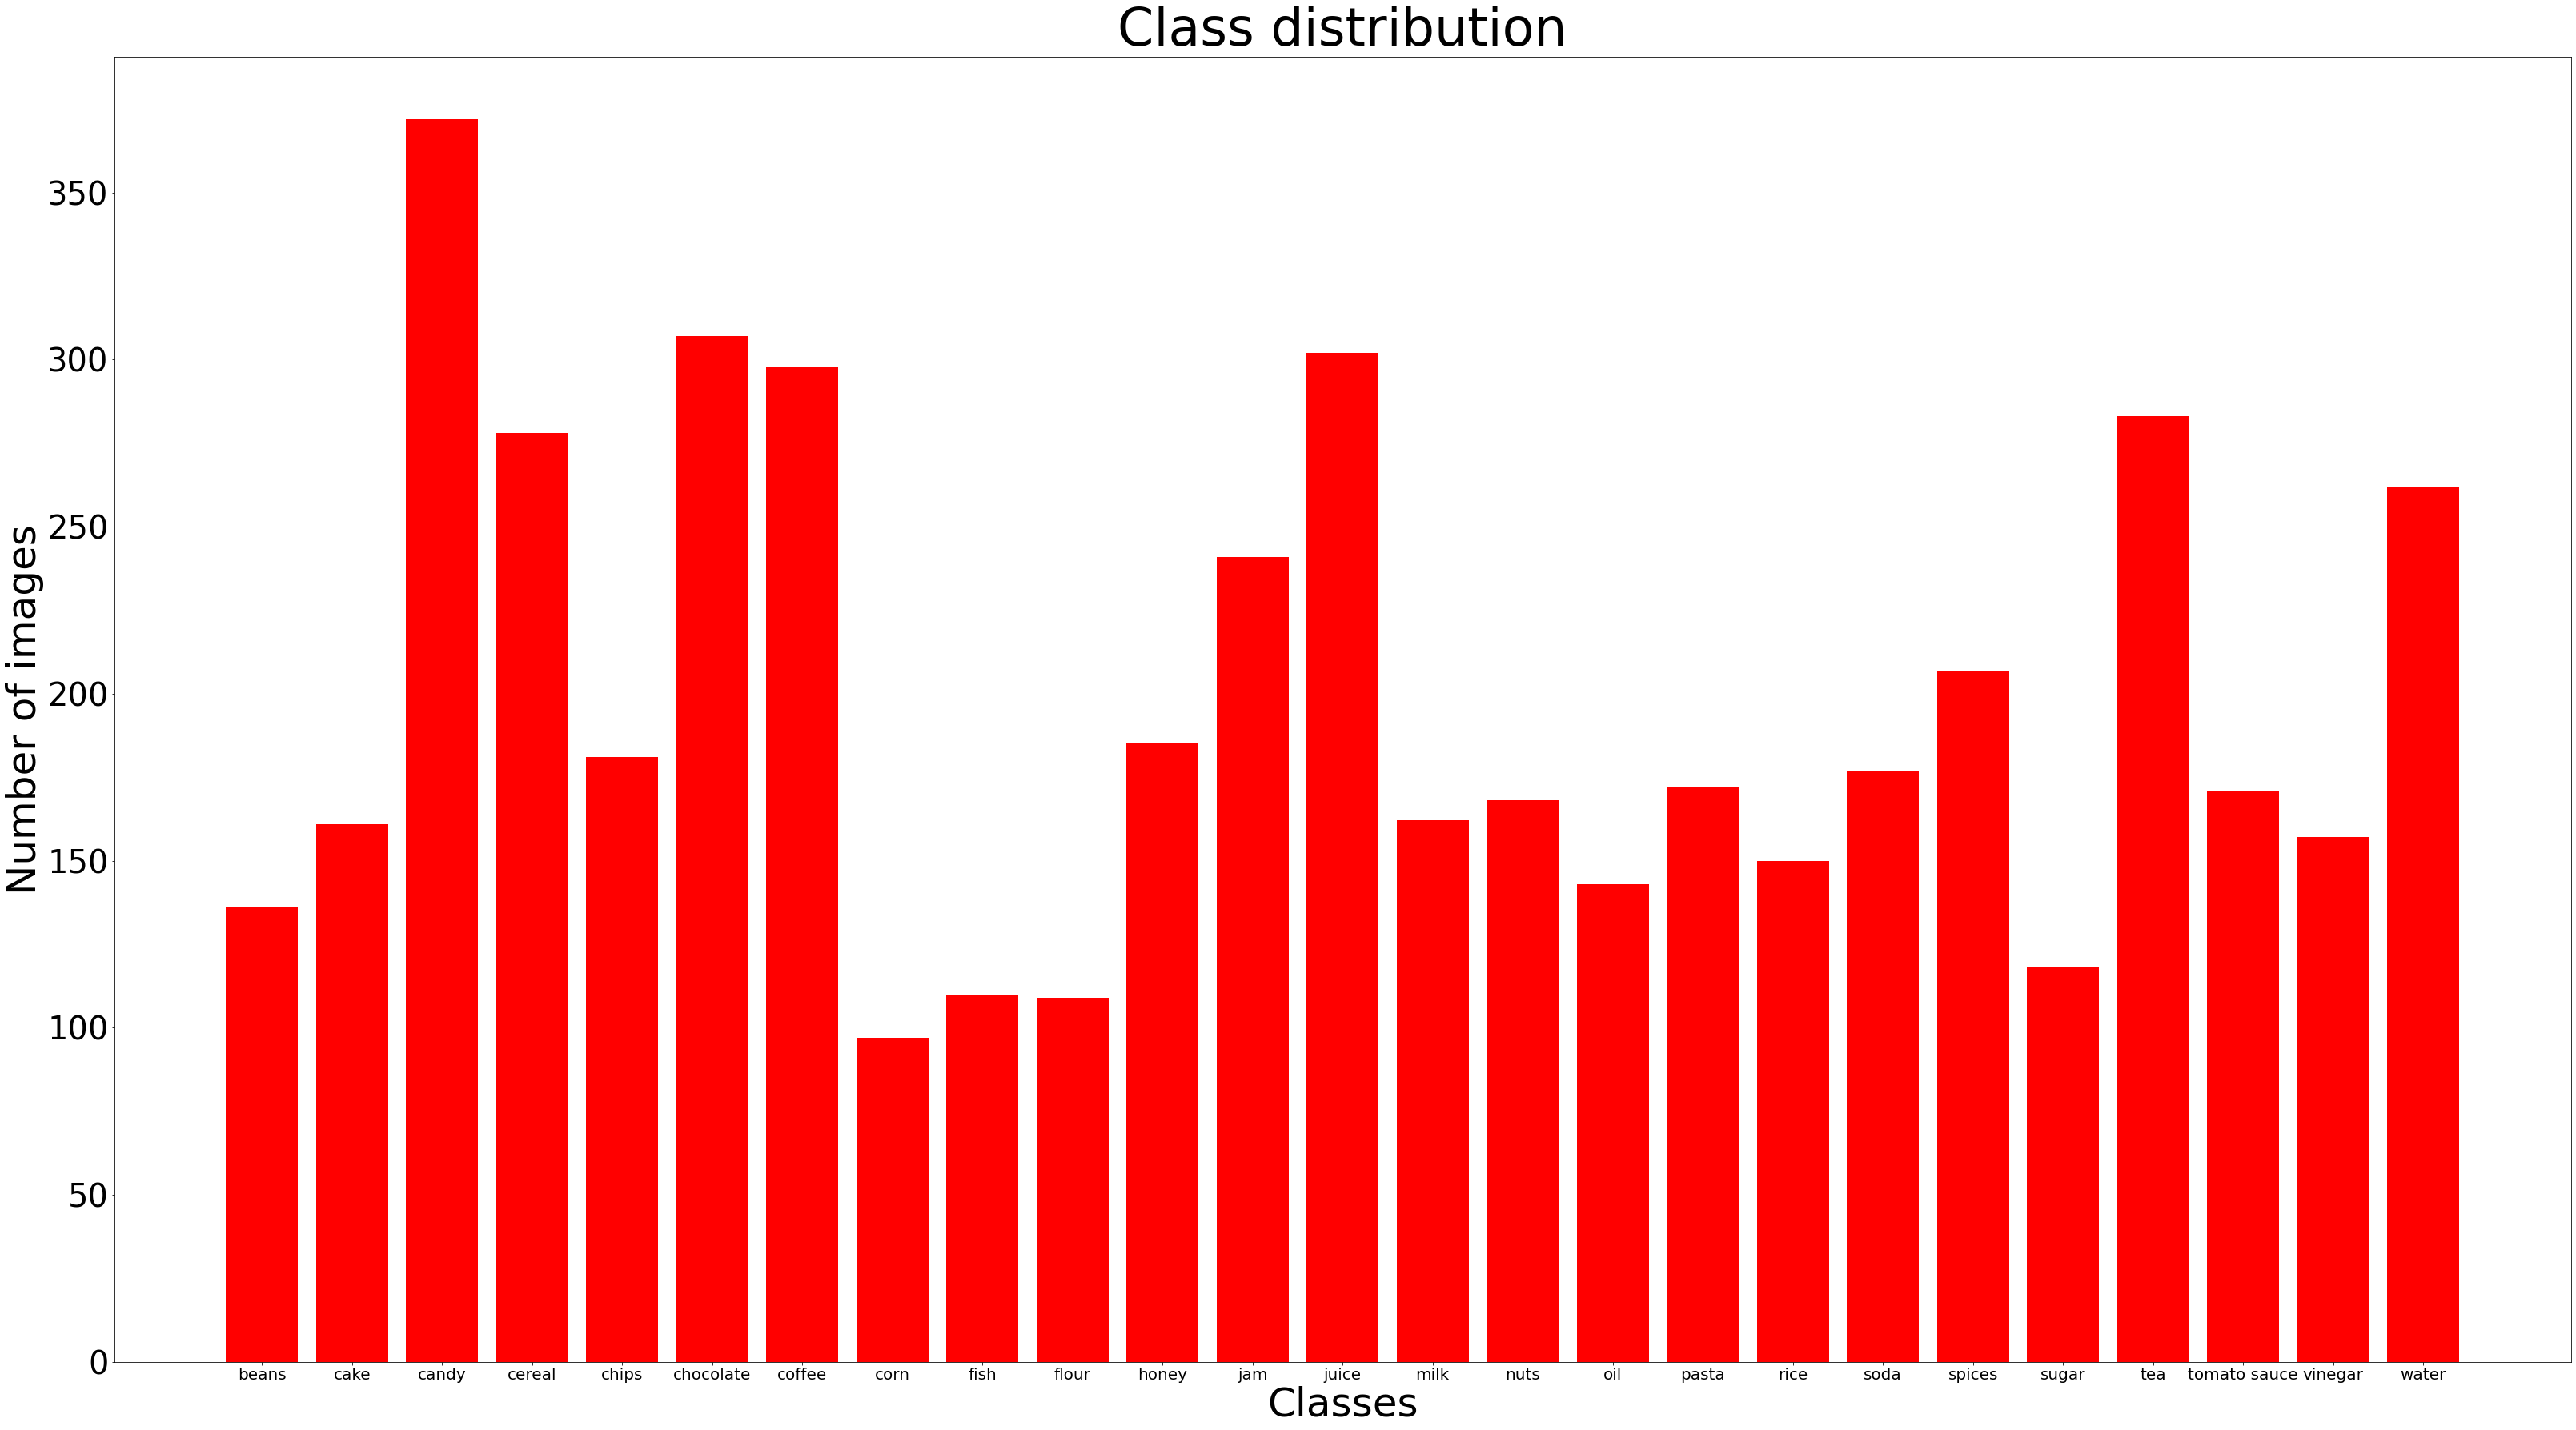

In [22]:
# bar diagram of class distribution
classes_names = ['beans','cake','candy','cereal','chips','chocolate','coffee','corn','fish','flour','honey',
                'jam','juice','milk','nuts','oil','pasta','rice','soda','spices','sugar','tea','tomato sauce','vinegar','water']
plt.figure(figsize=(55,30))
plt.title('Class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(Y), color = 'r')
plt.show()

In [23]:
Y = to_categorical(Y,25)

In [24]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [25]:
# The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
X = np.array(X)
X = preprocess_input(X)
# X = preprocess_input(X)
# we can preprocess input on imageDataGenerator

In [26]:
# data scaling here or afther on imageDataGenerator...
# X = X.astype('float32')
# X=X/255

In [27]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [28]:
# train - test - val split
# x_train_val, x_test, y_train_val, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_STATE,stratify=Y)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=RANDOM_STATE,stratify=y_train_val)
# x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

# split only on x_train - y_train because we will use ImageDataGenerator on x_train for validation instances
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=RANDOM_STATE,stratify=Y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3462, 150, 150, 3), (1485, 150, 150, 3), (3462, 25), (1485, 25))

In [29]:
# CHECK IF X_TEST HAVE ALL CLASSES

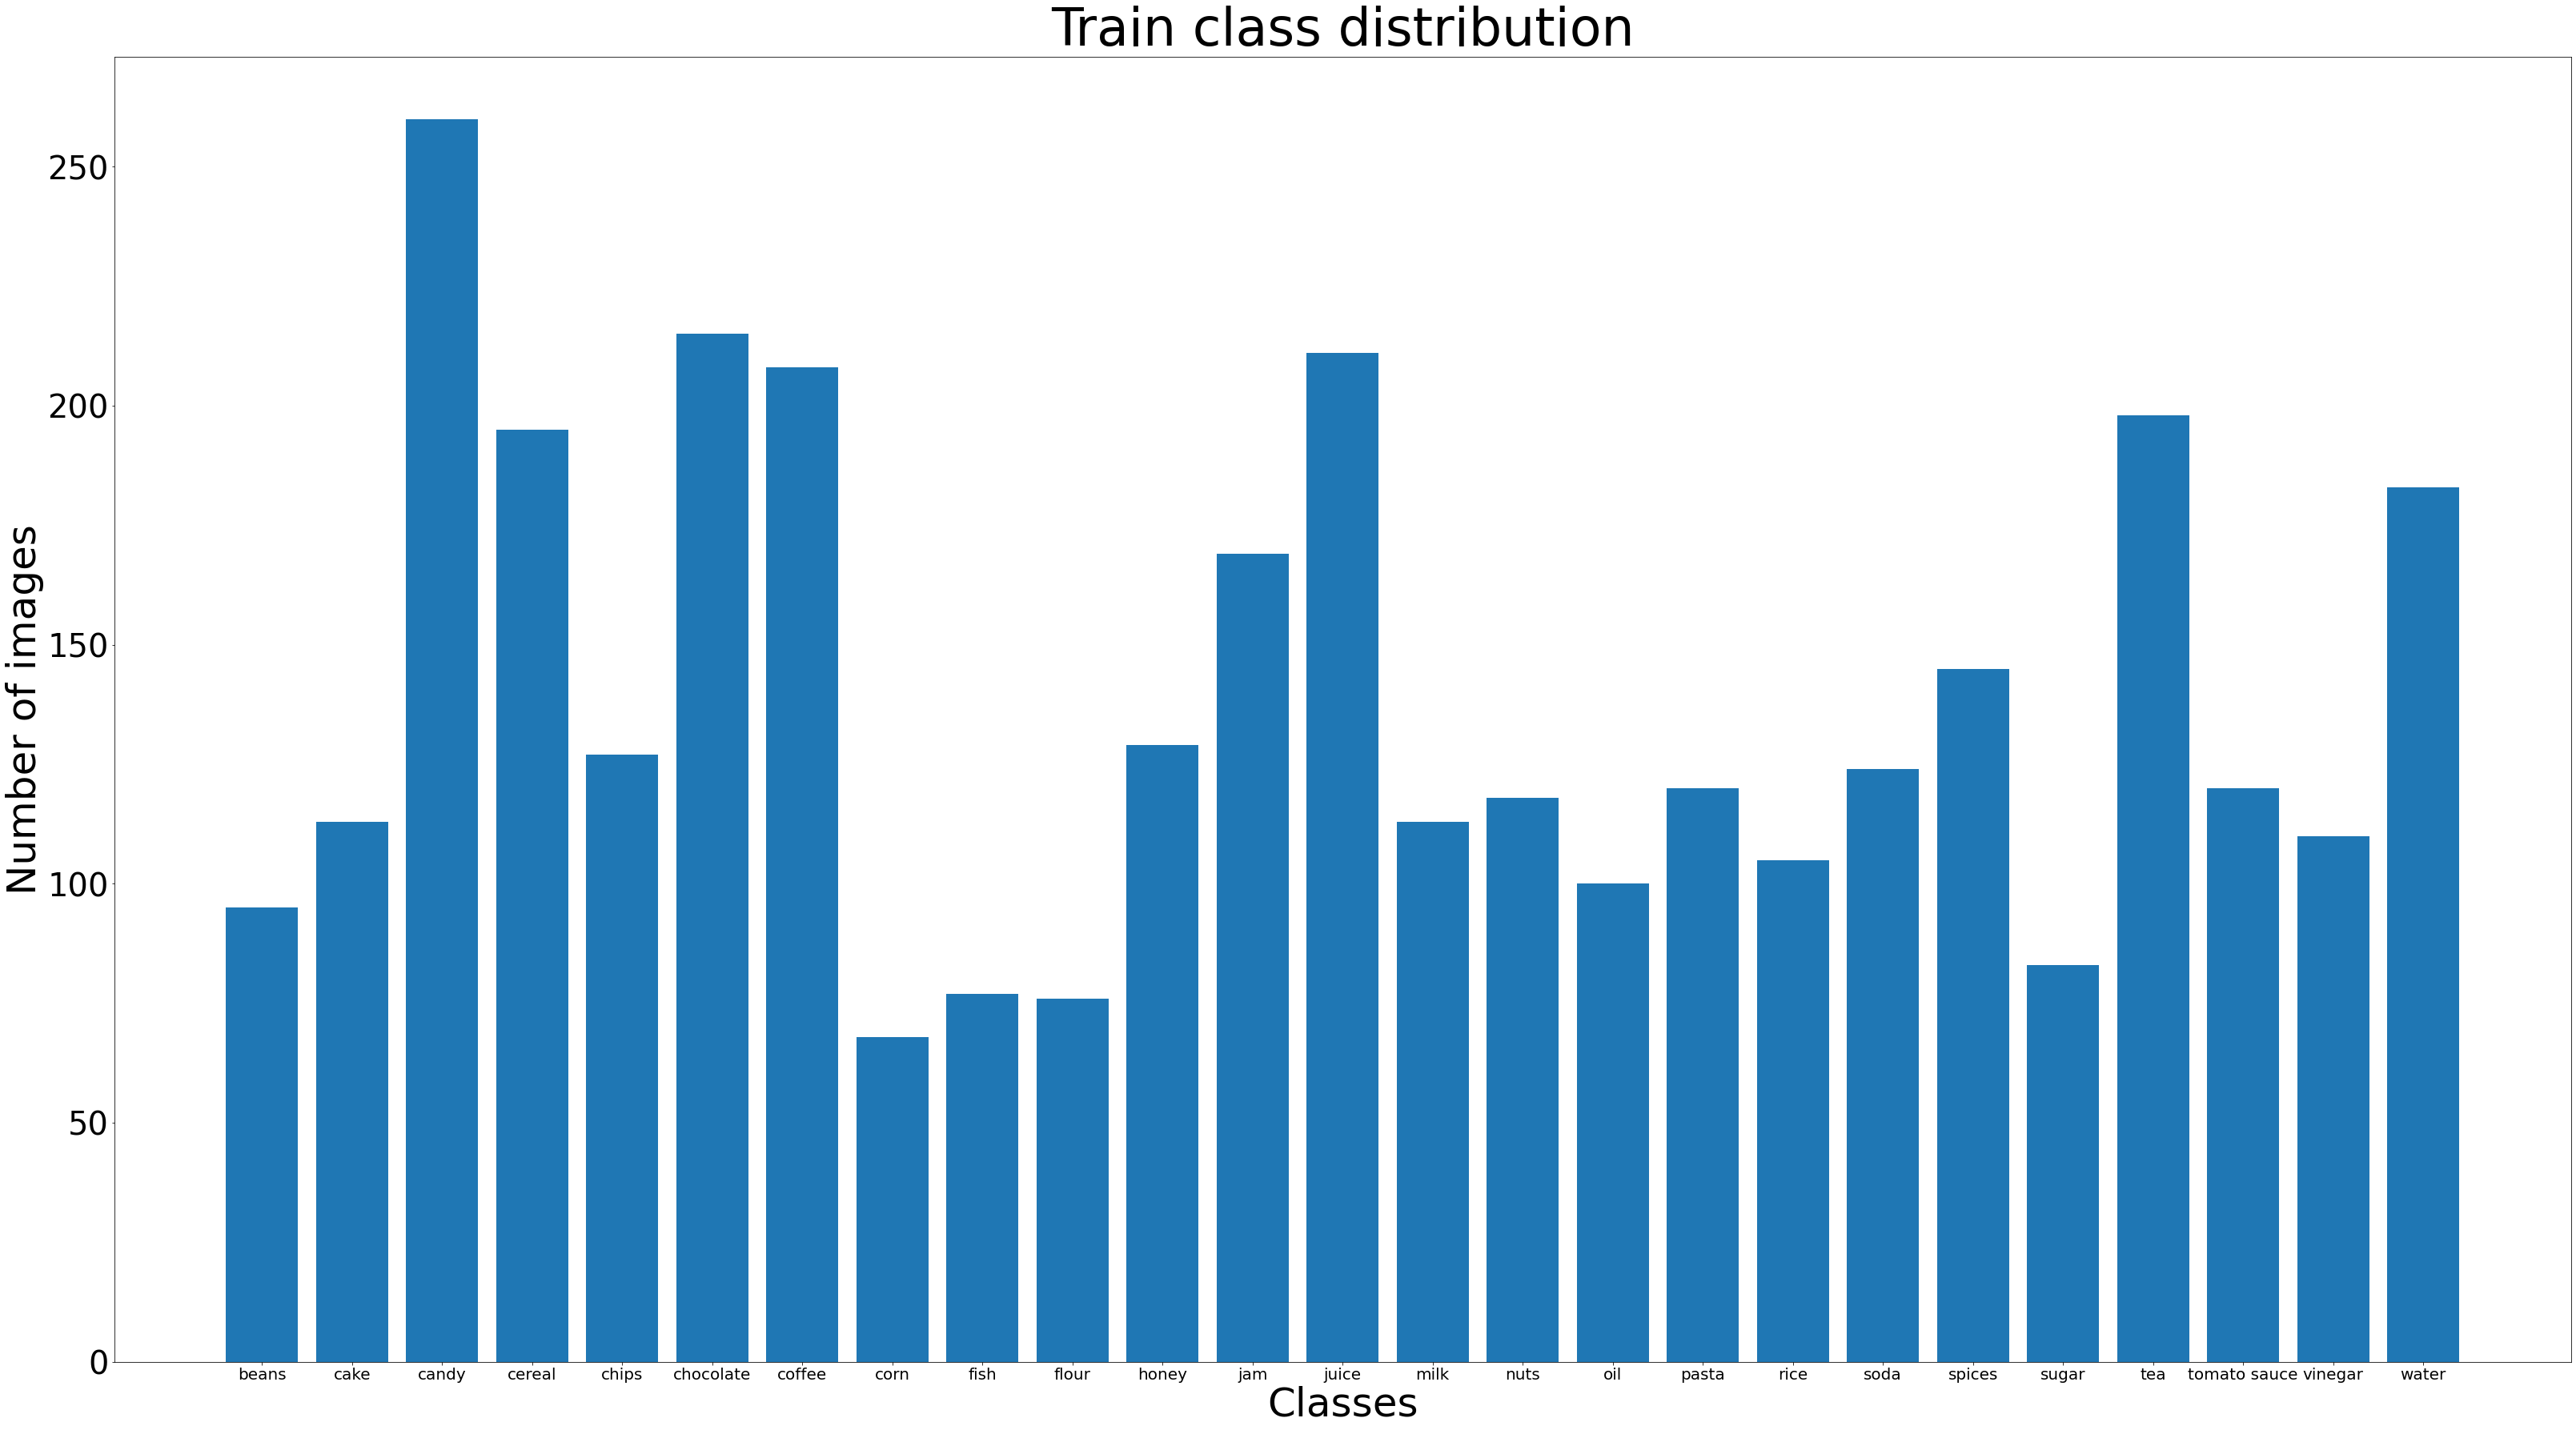

In [30]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_train_cls))
plt.show()

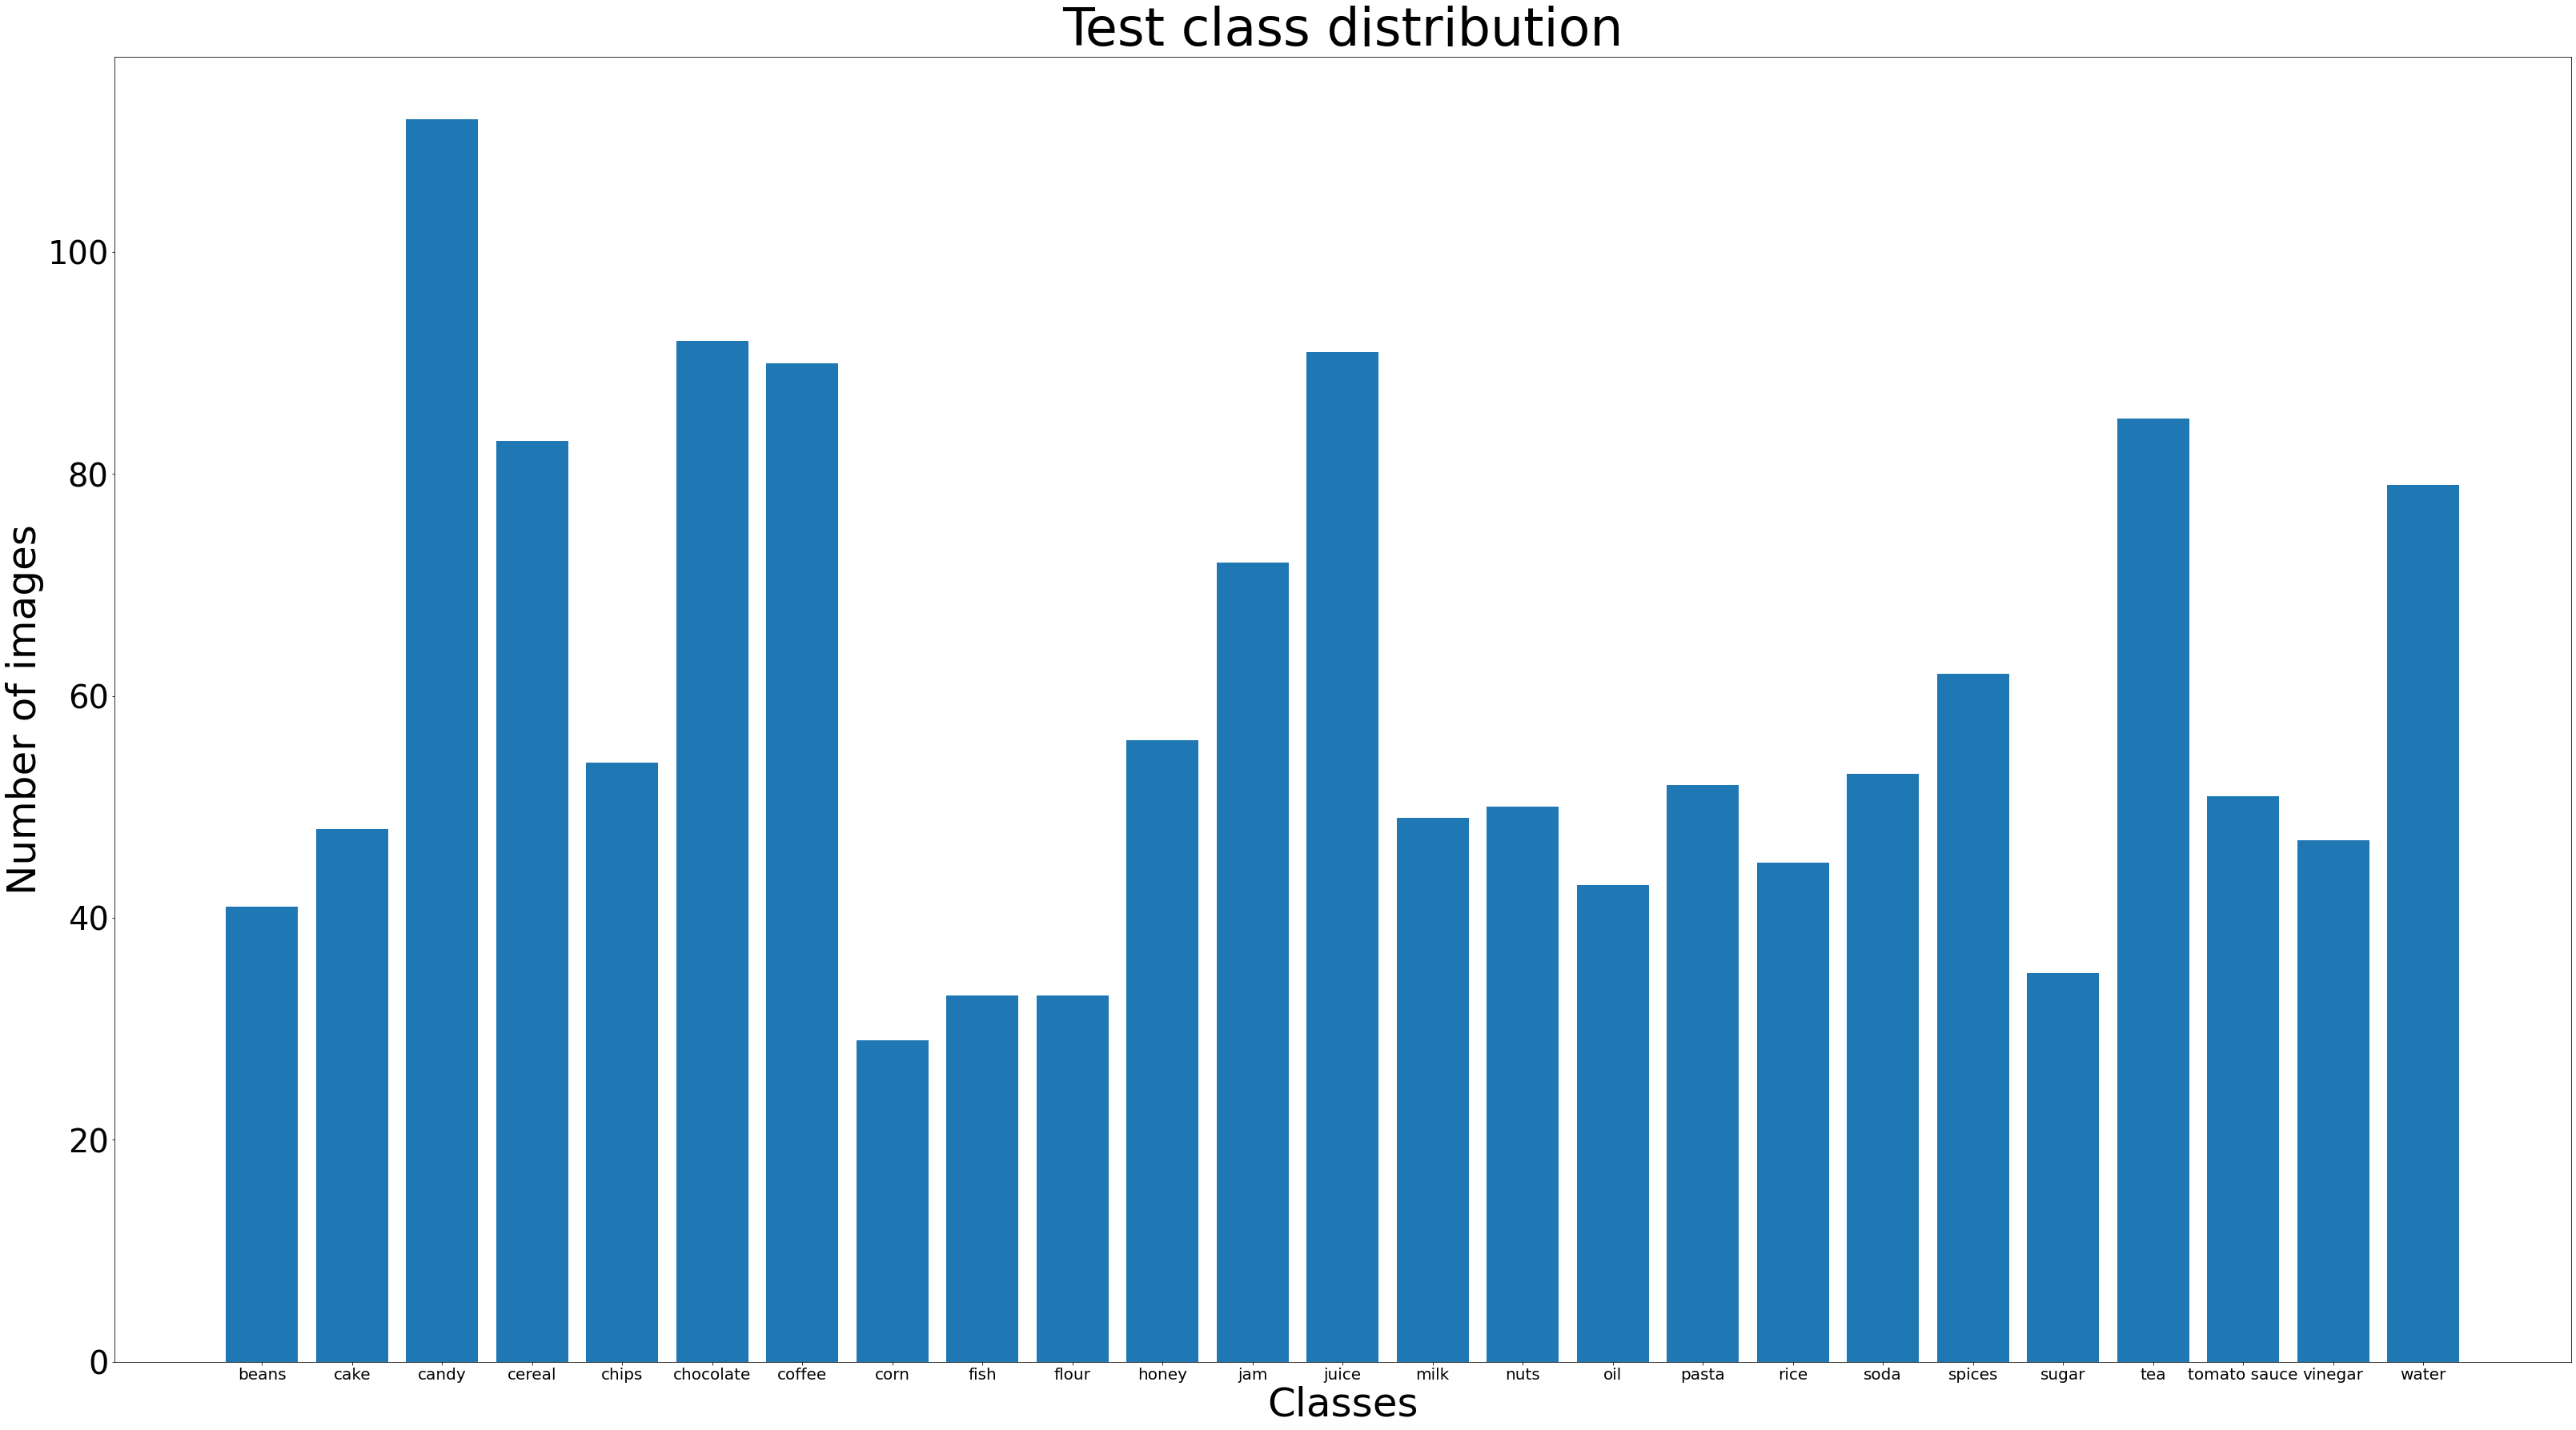

In [31]:
y_test_cls = np.argmax(y_test, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Test class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_test_cls))
plt.show()

In [32]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3,
#         rescale=1./255,
#         preprocessing_function=preprocess_input
) 

augs_gen.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

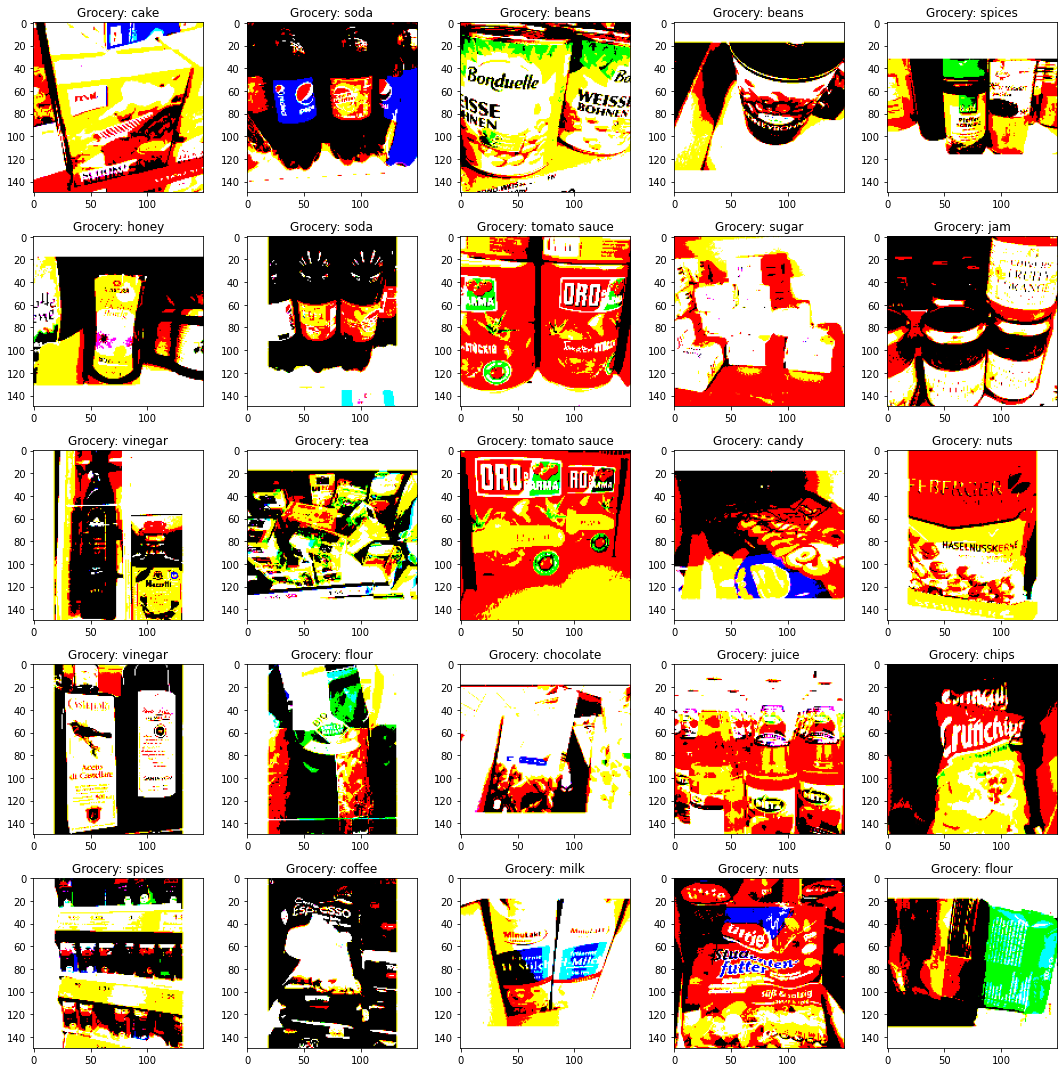

In [33]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        k = rn.randint(0, len(Z))
        ax[i,j].imshow(X[k])
        ax[i,j].set_title('Grocery: '+ Z[k])
        
plt.tight_layout()

In [34]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [35]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [36]:
# model = test_model()
model = vgg19_model(img_rows, img_cols)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000268F8EBA040> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FB15B460> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FB15B7F0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000268FA9F5E50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FA9FE130> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FA9FE850> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000268FA9F5C40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FAA0D610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FAA0DA30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FAA197F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000268FAA20940> False
<tensorflow.python.

In [37]:
print_model(model, path_to_vgg19_model_image)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [38]:
checkpoint = ModelCheckpoint(
    filepath=path_to_vgg19_model_weights,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

# TensorBoard provides the visualization
# tensorboard = TensorBoard(
#     log_dir = './vgg16logs',
#     histogram_freq=0,
#     batch_size=16,
#     write_graph=True,
#     write_grads=True,
#     write_images=False,
# )

csvlogger = CSVLogger(
    filename= path_to_vgg19_csvlog,
    separator = ",",
    append = False
)


# Reduce learning rate when a metric has stopped improving
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, csvlogger, reduce]

In [39]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
                    augs_gen.flow(x_train, y_train, batch_size = 32,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(x_train, y_train, batch_size=32, subset='validation'),
                    callbacks=callbacks
                    )

Epoch 1/50
76/76 [==============================] - 323s 4s/step - loss: 4.9798 - accuracy: 0.2401 - val_loss: 2.3750 - val_accuracy: 0.3767
Epoch 2/50
76/76 [==============================] - 319s 4s/step - loss: 2.0729 - accuracy: 0.4307 - val_loss: 2.0378 - val_accuracy: 0.4133
Epoch 3/50
76/76 [==============================] - 312s 4s/step - loss: 1.7016 - accuracy: 0.5025 - val_loss: 1.8595 - val_accuracy: 0.4711
Epoch 4/50
76/76 [==============================] - 311s 4s/step - loss: 1.4790 - accuracy: 0.5660 - val_loss: 1.8658 - val_accuracy: 0.4884
Epoch 5/50
76/76 [==============================] - 312s 4s/step - loss: 1.2761 - accuracy: 0.5957 - val_loss: 1.8751 - val_accuracy: 0.4904
Epoch 6/50
76/76 [==============================] - 317s 4s/step - loss: 1.1523 - accuracy: 0.6436 - val_loss: 1.8122 - val_accuracy: 0.4904
Epoch 7/50
76/76 [==============================] - 316s 4s/step - loss: 1.0756 - accuracy: 0.6671 - val_loss: 1.7470 - val_accuracy: 0.5135
Epoch 8/50
76

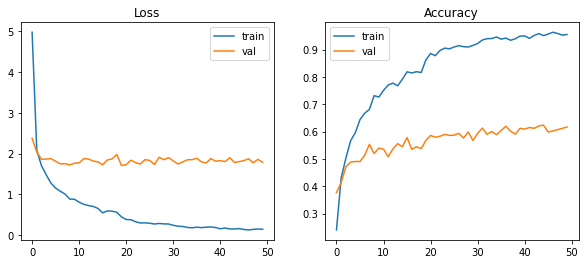

In [40]:
plot_acc_loss(history,num_of_epochs)

In [41]:
# MODEL EVALUATION

109/109 [==============================] - 358s 3s/step - loss: 0.5839 - accuracy: 0.8905
Test loss: 0.5838935971260071
Test accuracy: 0.8905256986618042
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        95
           1       0.92      0.86      0.89       113
           2       0.89      0.90      0.89       260
           3       0.77      0.89      0.83       195
           4       0.80      0.90      0.84       127
           5       0.86      0.82      0.84       215
           6       0.89      0.90      0.90       208
           7       0.92      0.87      0.89        68
           8       0.97      0.88      0.93        77
           9       0.83      0.84      0.84        76
          10       0.92      0.92      0.92       129
          11       0.93      0.96      0.94       169
          12       0.86      0.92      0.89       211
          13       0.89      0.88      0.89       113
          14       0.85      0.80  

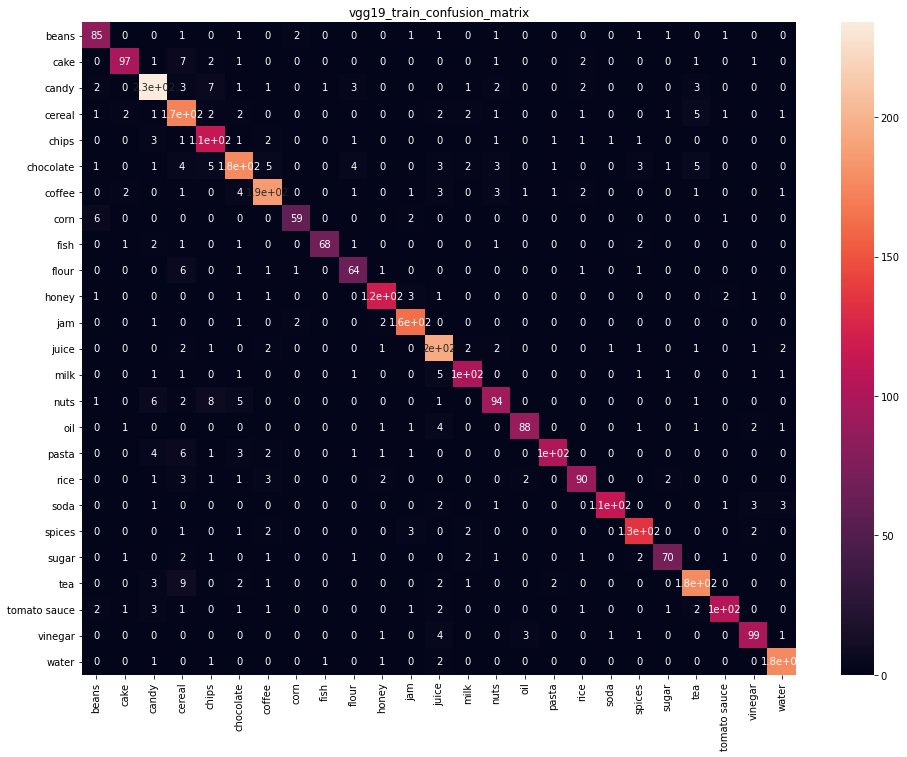

In [42]:
# TRAIN EVALUATION
evaluate_model(model,x_train,y_train,classes_names,"vgg19_train_confusion_matrix")

47/47 [==============================] - 147s 3s/step - loss: 1.7726 - accuracy: 0.6519
Test loss: 1.7725887298583984
Test accuracy: 0.6518518328666687
              precision    recall  f1-score   support

           0       0.66      0.61      0.63        41
           1       0.68      0.48      0.56        48
           2       0.72      0.73      0.73       112
           3       0.45      0.65      0.53        83
           4       0.58      0.72      0.64        54
           5       0.59      0.51      0.55        92
           6       0.58      0.62      0.60        90
           7       0.54      0.48      0.51        29
           8       0.67      0.67      0.67        33
           9       0.57      0.52      0.54        33
          10       0.76      0.70      0.73        56
          11       0.75      0.88      0.81        72
          12       0.63      0.74      0.68        91
          13       0.75      0.61      0.67        49
          14       0.51      0.38    

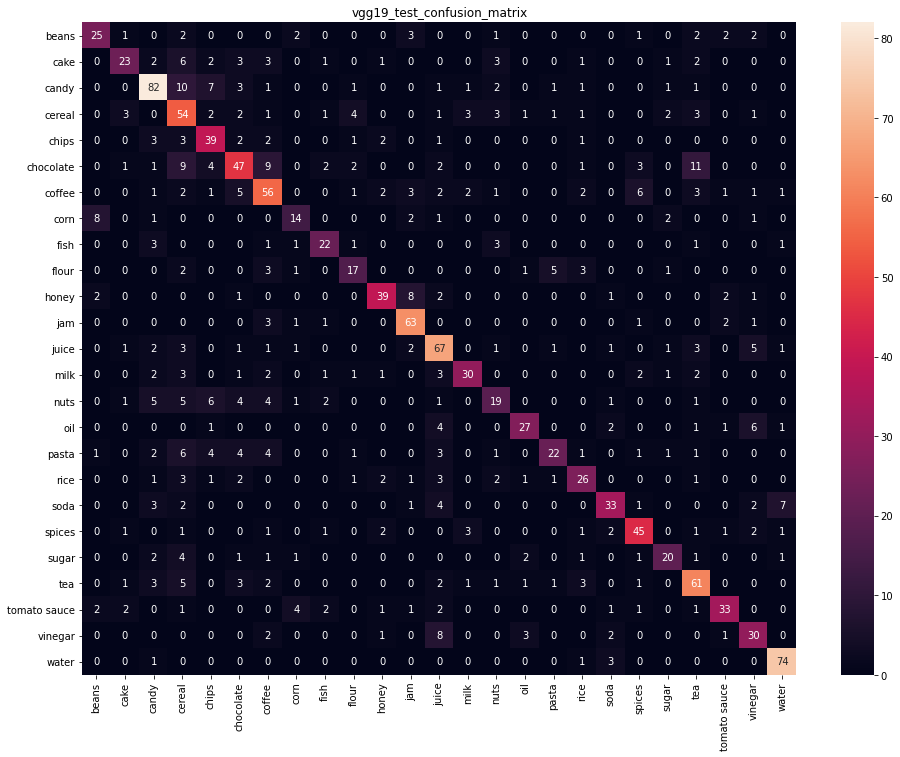

In [43]:
# TEST EVALUATION
evaluate_model(model,x_test,y_test,classes_names,"vgg19_test_confusion_matrix")

In [44]:
# take weights with max acc
# ret = model.load_weights(path_to_alexNet_model_weights)

In [45]:
# SAVING MODEL

In [46]:
write_model_as_json(model,vgg19_model_json_path)

In [47]:
model.save(path_to_vgg19_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/vgg19\assets


In [48]:
# model1 = load_model(path_to_vgg19_model_weights)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

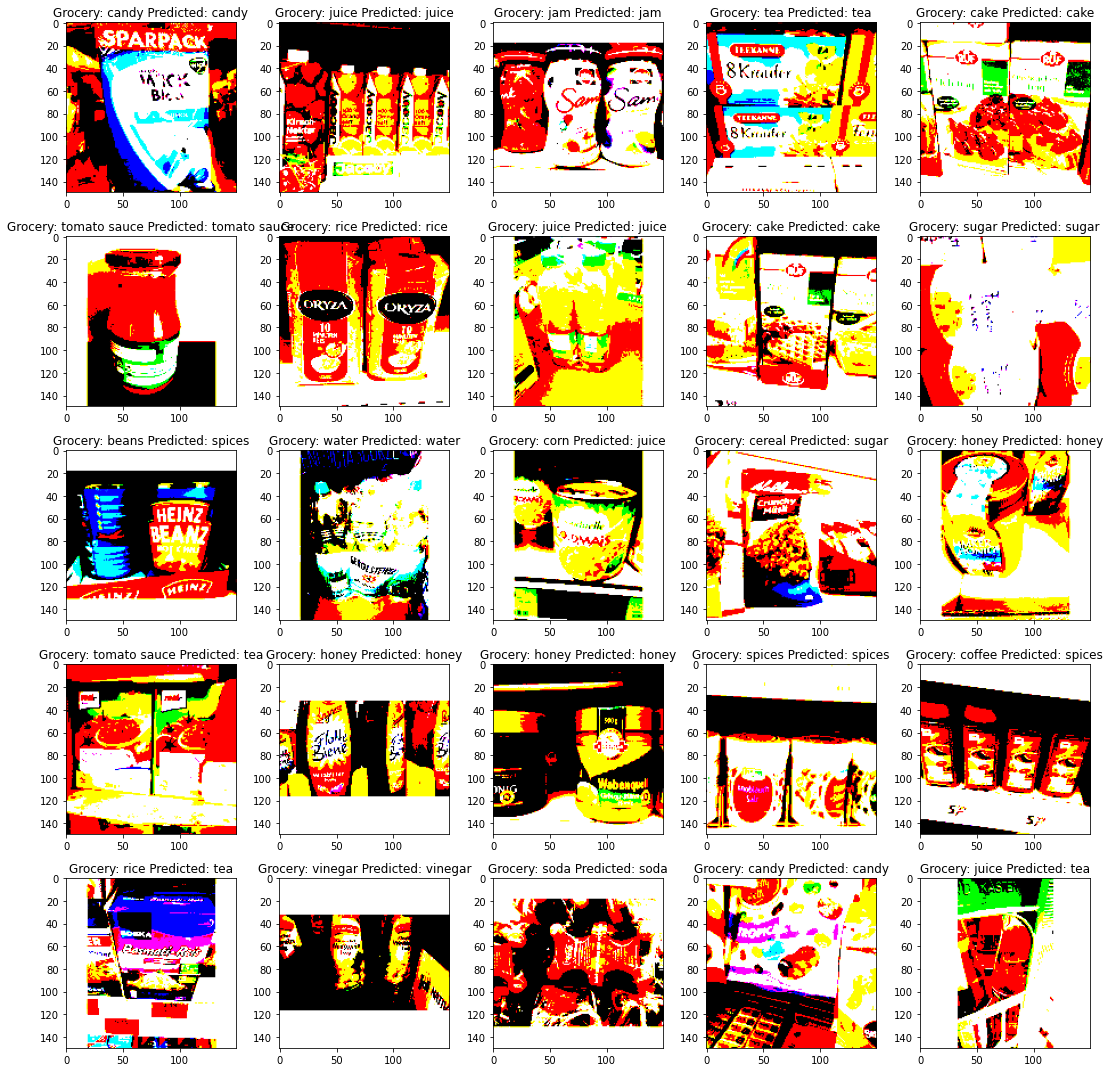

In [49]:
# evaluation on test
test_len = len(y_test)


fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(5):
        k = rn.randint(0, test_len - 1)
        ax[i,j].imshow(x_test[k])
        ax[i,j].set_title('Grocery: '+ classes_names[np.argmax(y_test[k])] + " Predicted: " + classes_names[np.argmax(model.predict(x_test[k:k+1]))])
plt.tight_layout()  